In [11]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from tqdm       import tqdm
from astropy    import units
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d, RegularGridInterpolator

from common import hallmark as hm
from common import mockservation as mk
from common import dalt
from common import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
pf = hm.ParaFrame('cache/SPO2023/gt/{NGC}_a{aspin:g}_i{inc:g}_{freq}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

inc [ 50. 160.]
aspin [-0.94 -0.5   0.    0.5   0.94]
NGC ['NGC3998' 'NGC4261' 'NGC4594']
freq ['230.e9' '345.e9' '86.e9']


In [13]:
sel = pf(freq='86.e9')(aspin=-0.5)(inc=160)(NGC='NGC3998')
sel

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v


,path,NGC,aspin,inc,freq
14,cache/SPO2023/gt/NGC3998_a-0.5_i160_86.e9.h5,NGC3998,-0.5,160.0,86.e9


In [14]:

def load(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    return dalt.Image(data, meta=meta)
        
mov = load(sel.path.iloc[0])
print(mov.shape)
#viz.show(mov, s=0)

(1000, 8, 8)


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/viz.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  v = v.value.astype(float)


<Axes: xlabel='u [G$\\lambda$]', ylabel='v [G$\\lambda$]'>

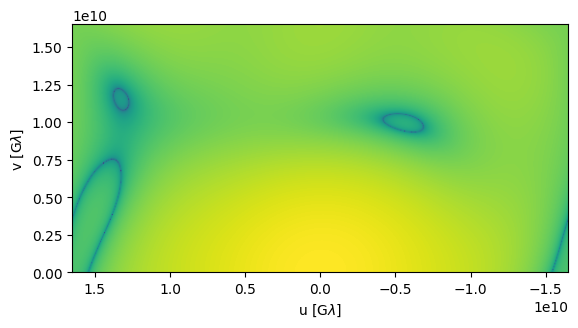

In [15]:
vis = mk.mockserve(mov, N=512)
viz.show(vis, s=0, f=lambda v: np.log(abs(v)))

In [16]:

U, V = vis.uvd

u = np.linspace( 0,   U/2, num=vis.shape[-1])
v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
t = vis.meta.time.value

amp = RegularGridInterpolator((t, v, u[::-1]), abs     (vis[...,::-1]))
phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))

1001


<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_1919/1335559105.py:36: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$u$-$v$ distance [G$\lambda$]')


Text(0, 0.5, 'Normalized visibility amplitude $|V/V_0|$')

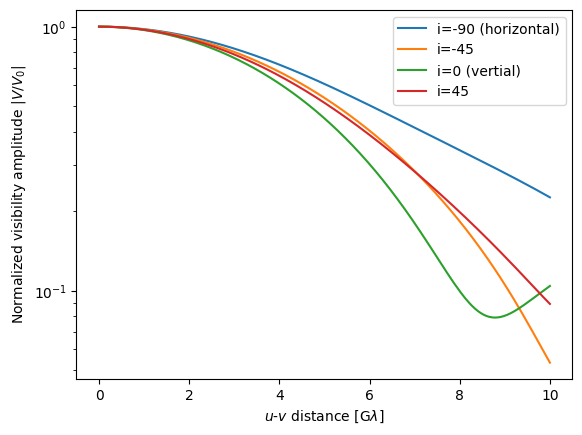

In [17]:
bmin = 6e9
bmax = 1e10

uvd = np.linspace(0, bmax, round(bmax/1e7)+1)
print(len(uvd))

for i in range(-90,90,45):
    phi = np.pi * i / 180

    u = uvd * np.cos(phi)
    v = uvd * np.sin(phi)

    mask = u <= 0
    
    p = np.array([np.repeat(t[0], np.sum( mask)),  v[ mask],  u[ mask]]).T
    m = np.array([np.repeat(t[0], np.sum(~mask)), -v[~mask], -u[~mask]]).T
    
    s = np.zeros(len(uvd))
    s[ mask] = amp(p)
    s[~mask] = amp(m)
        
    label = f'i={i}'
    if i == -90:
        label += ' (horizontal)'
    elif i == 0:
        label += ' (vertial)'
    plt.semilogy(uvd/1e9, s/s[0], label=label)#, ':' if i < 0 else '-')

    #lm = argrelextrema(s, np.less)[0]
    #plt.scatter(uvd[lm], s[lm]/s[0])
    
    #ms = np.median(s[(bmin < uvd) & (uvd < bmax)]) / s[0]
    #plt.plot([bmin, bmax], [ms, ms], ':' if i < 0 else '-', alpha=1/3)

plt.legend()
plt.xlabel('$u$-$v$ distance [G$\lambda$]')
plt.ylabel('Normalized visibility amplitude $|V/V_0|$')